# Integration of Particle Orbits

The integration of particle paths is on the one hand a non-trivial issue, in that one must be careful when choosing the method of integration, so particles don't lose or gain energy for purely numerical reasons.  On the other hand there does exist a simple and robust method; the kick-drift-kick (KDK) method, which is good enough for most practical purposes, except maybe longterm integration of planetary orbits.

### Overview
The purpose of this exercise is to give you a feeling for how many steps per orbit are needed to obtain a reasonable precision, and what kinds of errors that are avoided by using an energy conserving, "symplectic" (cf. Section 3.6 in the book) method.

### Setup
This notebook initialises `n` particles in the central potential of a star. _Keplerian_ units of mass = 1 solar mass, length = 1 au, and time = 1 yr are chosen such that GM = $4\pi^2$ for a 1 solar mass star. The particle orbits have radii `rad` with some normal distributed distribution with std dev `dispersion`. You will add to this an `eccentricity` (0 for circular, 1 for direct infall) with a normal distributed spread `edispersion` centered on ``e=0``. Since normal distributed variables can have arbitrarily large positive and negative values around the mean we limit the radial distribution to the interval `[rmin, rmax]`and the eccentricity to be below `emax`.

### The Kepler problem
The Kepler problem is a simplified two-body problem, where one of the bodies is a mass-less test particle. The motion is characterised by the two constants of motion. The specific (per mass) energy is:

\begin{equation}
E = {1 \over 2} v^2 - {GM \over r}
\end{equation}
and the specific (per mass) angular momentum is
\begin{equation}
L = r \times v
\end{equation}
The acceleration of the test particle is given from Newton's law of gravitation

\begin{equation}
\mathbf{a} = - \frac{GM}{r^2} \frac{\mathbf{r}}{r}
\end{equation}
For the special case of circular motion we have
\begin{equation}
v_\textrm{circle} = v_\textrm{Kepler} = \sqrt{\frac{GM}{r}}
\end{equation}
and the specific energy is $E_\textrm{circle} = - {1 \over 2} {GM \over r}$.

In the general case the orbit is an ellipse. The eccentricity of the ellipse can be caluculated from the specific energy and angular momentum as
\begin{equation}
e = \sqrt{1 + \frac{2 E L^2}{(GM)^2}}
\end{equation}
the orbit period $P$ and the semi-major axis $a$ are related to the specific energy as

\begin{align}
E  & = - {1 \over 2} {GM \over a} \\
P^2 & = \frac{4\pi^2}{GM} a^3
\end{align}

If the specific energy is positive, the particle is unbound.

These few key equations a enough to setup a simple Kepler problem with a given eccentricity and radius as done below. 

### Preparations:
1. Apart from secular (slow and systematic) changes in total energy, there are also other types of errors.  Paths that should be exactly elliptic can have nutation, for example, where the aphelion / perihelion positions rotate a small amount for each orbit. Such a path is typically also associated with a variation of total energy along the path so that, even though energy is conserved over full orbits, it is not conserved exactly during one orbit. Examples of that are in the slides, and you will also create your own below.
2. Review the setup below. The notebook contains a `Particles` class with basic particle data and related routines for computing radius, speed, energy, and orbital time.
3. The other class is called `Integration`. It contains a Kick-Drift-Kick integrator and a classical 3rd order Runge-Kutta (RK3) integrator. The KDK integrator has the optional `reflexive` option setting the timestep based on both the current and the future value of the timestep, to make the integration routine symmetric in time. It also has a simple Courant condition that is based on taking `norbit` steps per orbital time.
4. _Take your time_ to review the comments in the `__init__` procedure for each `class`. If you do not understand what the purpose of an option is, please ask.
5. Below the two class definitions is a small example of how to use the setup. With a low number of particles, the time, timestep (dt), position, and total energy of each particle is stored as a function of time, and a few statistics and orbital plots are made. This will help you understand the behaviour of the integrator with different sets of options.

In [1]:
import numpy as np                      # Import numpy and matplotlib.pyplot
import matplotlib.pyplot as plt
from time import time                   # Import time procedure for timing measurement
np.set_printoptions(linewidth=120)      # Expand the nr of columns used for printing
np.seterr(invalid='raise');             # Fail the code if any exception is raised 
from scipy.signal import find_peaks

In [2]:
class Particles():
    def __init__(self, n=50, rad=1., rmin=0.4, rmax=4., dispersion=0.1, \
                 edispersion=0.1, emax=0.95, starmass=1., seed=1234):
        self.n = n                          # number of particles
        self.rad = rad                      # radius [in AU] at which particles are inserted
        self.rmin = rmin                    # minimum and maximum initial radius
        self.rmax = rmax
        self.dispersion = dispersion        # dispersion [in AU] around radius
        self.edispersion = edispersion      # dispersion in eccentricity
        self.emax = emax                    # maximum eccentricity
        self.starmass = starmass            # stellar mass [solar masses]

        # Assume units where [M] = solar mass, [l]=AU, [t]=year.
        # Then the (unit-less) Kepler's law hold true and GM = 4 pi^2 for Sun.
        self.GM = 4. * np.pi**2 * self.starmass
        
        # Setup particles
        self.r = np.zeros((3,n))            # position
        self.v = np.zeros((3,n))            # momentum
        self.initialize(seed)
        
    def initialize(self,seed):
        """ Initialize random particles uniformly in angle with a dispersion
            in radius and eccentricity. Place all particles at aphelion.
        """
        np.random.seed(seed)
        
        # Radius equal initially to apastron (normal distributed)
        self.rm = np.random.normal(loc=self.rad, scale=self.dispersion, size=self.n) # dispersion is normal distributed
        self.rm = np.clip(self.rm,self.rmin,self.rmax)   # limit semi-major axis inside rmin and rmax

        # Eccentricity (normal distributed)
        # self.e = ...
        self.e = np.zeros(self.n) # circular orbit

        # Phase compared to coordinate (self.rm,0) (uniform distributed)
        angle = np.random.uniform(low=0., high=2.0*np.pi, size=self.n)
        
        # position
        self.r[0] = self.rm*np.cos(angle)
        self.r[1] = self.rm*np.sin(angle)

        # velocity
        self.vm = np.sqrt(self.GM/self.rm)              # Kepler speed
        # ... correct velocity to take in to account eccentricity ...
        self.v[0] = -self.vm*np.sin(angle)
        self.v[1] = +self.vm*np.cos(angle)
        print(self.v[0])
    
    def radius(self):
        """ Compute the scalar radii from the vector positions """
        self.rm = np.sqrt(np.sum(self.r**2,0))        

    def speed(self):
        """ Compute the scalar speeds from the vector velocity components """
        self.vm = np.sqrt(np.sum(self.v**2,0))
        
    def energy(self):
        """ Compute specific energy for particles """
        self.radius()
        self.speed()
        self.E = 0.5*self.vm**2 - self.GM / self.rm
        
    def Porbit(self):
        """ compute orbit time for particles """
        self.energy()
        a = - 0.5 * self.GM / self.E                          # semi-major axis
        a[np.where(a < 0.)] = a.max()                         # let a be largest possible for negative a,
                                                              # since those are unbound orbits
        return 2. * np.pi * a * np.sqrt(a) / np.sqrt(self.GM) # Period of orbit

In [3]:
class Integration():
    def __init__(self, p, Integrator='kdk', Courant='acceleration', \
                          norbit=100, reflexive=0):
        """ Setup integrator. p is a particle class with particle data """
        self.norbit = norbit               # dt control: nr of steps for a single orbit 
        self.Cdt = 2.*np.pi / norbit       # corresponding criteria for acceleration dt CFL condition

        # if self.reflexive>0 then use "reflexive" nr of trial steps to determine a time-symmetric dt for adaptive timestep
        self.reflexive  = reflexive
        
        self.nstep = 0                     # iteration step
        self.time = np.zeros(p.n)          # time
        self.dt = np.zeros(p.n)            # dt
        self.GM = p.GM                     # Transfer granvitational mass

        # choose integration method
        if Integrator=='kdk':
            self.Int = self.kdk
        if Integrator=='rk3':
            self.Int = self.rk3
        
        # choose Courant condition method
        if Courant=='orbit':
            self.courant = self.courant_orbit
        if Courant=='acceleration':
            self.courant = self.courant_acceleration
        
    def acceleration(self,r):
        """ Compute the gravitational acceleration at positions r """
        rm = np.sqrt(np.sum(r**2,0))
        return -r*self.GM/(rm*rm*rm)
        
    def kick(self,p):
        """ Update the velocity with half a time step """
        p.v = p.v + (0.5*self.dt)*self.acceleration(p.r)

    def drift(self,p):
        """ Advance the positions with a time step """
        p.r = p.r + self.dt*p.v

    def kdk(self,p):
        """ Take a single Kick-Drift-Drift timestep """
        # if reflexive dt condition used, store old particle positions, velocities, and dts
        # remember to use "np.copy" to take a real copy of the variables.
        #if self.reflexive > 0:
            # ...

        self.kick(p)
        self.drift(p)
        self.kick(p)
        
        # if reflexive dt condition used, recompute dt, and
        # use averaged dt to redo the KDK step "self.reflexive" times
        # from stored positions and velocities
        #if self.reflexive > 0:
            # make n more iteration for completeness
            #for i in range(self.reflexive):
                # ...

    def rk3(self,p):
        """ Take a single 3rd order Runge-Kutta timestep. See e.g.
            http://www.mymathlib.com/diffeq/runge-kutta/runge_kutta_v1_3.html
            for algorithm """
        dr1 = self.dt * p.v
        dv1 = self.dt * self.acceleration(p.r)
        
        dr2 = self.dt * (p.v + 0.5 * dv1)
        dv2 = self.dt * self.acceleration(p.r + 0.5 * dr1)
        
        dr3 = self.dt * (p.v - dv1 + 2.*dv2)
        dv3 = self.dt * self.acceleration(p.r - dr1 + 2.*dr2)
        
        p.r += (dr1 + 4.*dr2 + dr3) / 6.
        p.v += (dv1 + 4.*dv2 + dv3) / 6.
        
    def courant_orbit(self,p):
        """ Determine dt such that norbit steps are taken to complete an orbit """
        P = p.Porbit()                       # Compute orbit time
        # See Porbit function: Unbound particles are set to have an orbit with the largest bound particle P / dt
        self.dt = P / self.norbit            # update dt
            
    def courant_acceleration(self,p):
        """ Determine dt based on acceleration and velocity """
        acc = np.sqrt(np.sum(self.acceleration(p.r)**2,0))
        p.speed()
        self.dt[:] = self.Cdt * p.vm / acc
        
    def step(self,p):
        """ Take a single timestep """
        self.Int(p)             # The integrator is selected with the "Integrator" option at init
        self.time += self.dt
        self.nstep += 1

[ 5.48910689  7.00199015 -4.03211823  2.43416958  0.13155955 -0.50030508  5.74445865  4.52218058 -4.7086772
  5.61114066]
Energy min, aver, max, std : -35.8 -21.5 -15.3 5.7
Radius min, aver, max, std : 0.55 0.97 1.29 0.21
Speed  min, aver, max, std : 5.54 6.51 8.46 0.82
5470.9 nanosec/particle-step
Number of particles=10 and integration steps=356: 
Min time=1.4593 and end time=1.4593: 


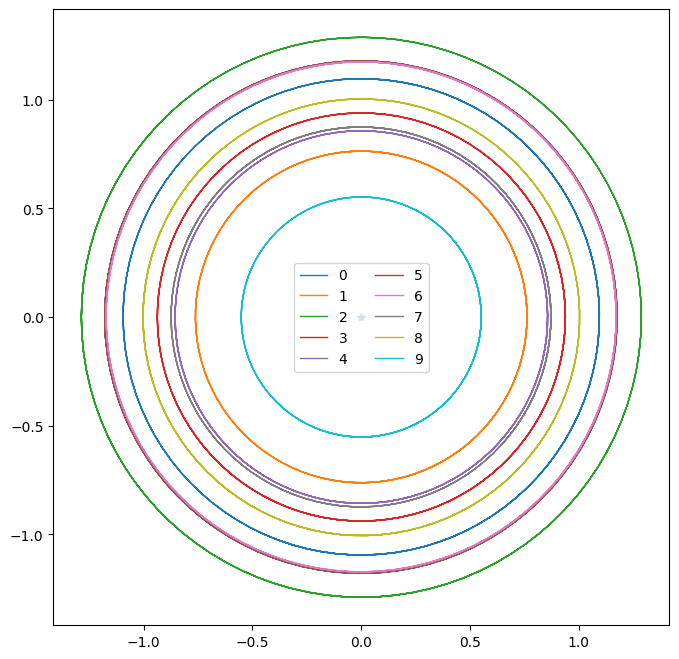

In [4]:
# Setup particle distribution
p=Particles(n=10,rad=1.,dispersion=0.2,edispersion=0.7)

# Print some statistics
p.energy(); p.radius(); p.speed()
print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))

# Setup integrator
I = Integration(p,Integrator='kdk',Courant='acceleration', \
                  norbit=100,reflexive=0)

# if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
# If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
# use_constant_dt = True should not be used in the tasks below.
use_constant_dt = False

# Make lists to store data for plotting and analysis
# Important to use np.copy, because otherwise just a pointer to data is made
r = []; r.append(np.copy(p.r))                       # store position
v = []; v.append(np.copy(p.v))                       # store velocity
energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
ptime = [np.copy(I.time)]                            # store time
dt = [np.copy(I.dt)]                                 # store dt

# Set timestep at start of integration!
if use_constant_dt:
    I.courant(p)

# If set to True, store positions and velocities as a function of time in r, v
store_orbits_and_plot = True

# Integrate at least 1 orbit for all particles, but for maximum "use" seconds
# Notice that each particle integrates with its own timestep.
tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
used = 0.0     # Time used in seconds
use = 10.      # Max time used for integration of orbits in seconds
while (used < use and I.time.min() < tend):
    start = time()
    if not use_constant_dt:
        I.courant(p) # Set timestep at start of integration step
    I.step(p)
    used += time()-start
    
    # store energy, time, and dt
    p.energy(); energy.append(np.copy(p.E))
    ptime.append(np.copy(I.time))
    dt.append(np.copy(I.dt))
    
    # store orbit
    if store_orbits_and_plot:
       r.append(np.copy(p.r))
       v.append(np.copy(p.v))

# Performance timining
print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

# Transpose arrays to make it easier to plot and analyse afterwards
energy = np.array(energy).transpose(1,0)
ptime = np.array(ptime).transpose(1,0)
dt = np.array(dt).transpose(1,0)
if store_orbits_and_plot:
    r = np.array(r).transpose(2,1,0)
    v = np.array(v).transpose(2,1,0)

# Make figure with orbits of particles    
if store_orbits_and_plot:
    plt.figure(figsize=(11,8))
    for i in range(r.shape[0]):
        plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
    plt.plot([0],[0],marker='*')
    plt.legend(ncol=2)
    plt.axis('scaled')
    plt.show()

Cdt : 0.06283185307179587
Initial eccentricity : 0.0
Initial energy:  -21.055838359562273
Average energy as a function of time:  -21.05579671964602
Std dev energy as a function of time:  2.91807350524692e-05


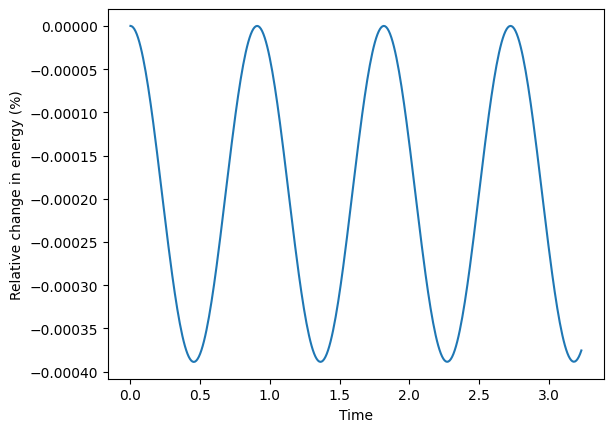

In [5]:
i_particle=3  # select particle track to plot energy for. Uses labels above.
plt.plot(ptime[i_particle],(energy[i_particle] / energy[i_particle,0]-1.)*100.)
plt.xlabel('Time')
plt.ylabel('Relative change in energy (%)')
#plt.ylim([-1.,2.])

# Information about run
print("Cdt :", I.Cdt)
print("Initial eccentricity :", p.e[i_particle])
print("Initial energy: ",energy[i_particle,0])
print("Average energy as a function of time: ",np.mean(energy[i_particle]))
print("Std dev energy as a function of time: ",np.std(energy[i_particle]));

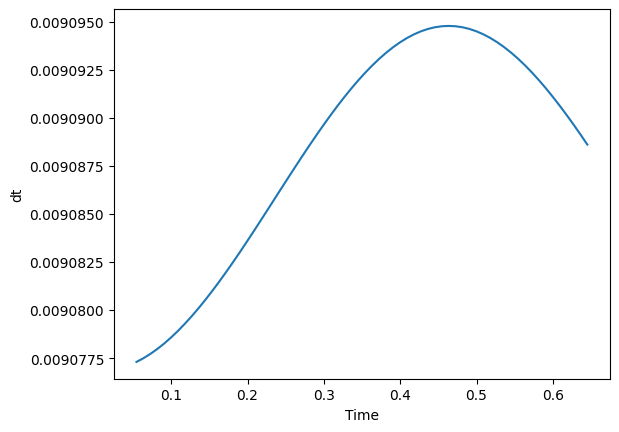

In [6]:
# Investigate change in dt at time of "kick"
i_particle=3  # select particle track to plot energy for 
w = np.where(np.abs(ptime[i_particle]-0.35) < 0.3)
plt.plot(ptime[i_particle,w].squeeze(),dt[i_particle,w].squeeze())
plt.xlabel('Time')
plt.ylabel('dt');

Notice that in the time integration routine above the call to the courant condition is inside the time loop. Set ``use_constant_dt=True`` to only compute the Courant condition once in the begining and get constant time-stepping.

#### __Task 1: Extend the initial condition to include eccentric orbits__
In the current setup all orbits are circular. This is not much fun. Circular orbits in a central potential are trivial to integrate. Therefore, extend the ``initialize`` such that it creates eccentric orbits using the two variables ``edispersion`` and ``emax`` in the particle class to make normal distribution for the eccenticity of individual particle orbits. You can make use that a negative eccentricity is equal to a positive one, so the normal distribution is always centered at ``e=0``.

#### __Task 2: Make the KDK have a time symmetrized dt__
As discussed in http://adsabs.harvard.edu/abs/1995ApJ...443L..93H a symplectic integrator with a variable timestep is not symplectic anymore. The simplest reason is that it is not time reversible, but the underlying Hamiltonian (e.g. the physical system) is. To improve on this, it has been suggested that if we instead define $\Delta t$ to be the average of $\Delta t$ at the start and end of the integration step
\begin{equation}
\Delta t = [ \Delta t(t_\textrm{old}) + \Delta t(t_\textrm{new}) ] / 2
\end{equation}
then the solution will be time-symmetric. One way to do this is after the KDK step to
recompute $\Delta t$ as $\Delta t(t_\textrm{new-1})$, construct a new $\Delta t$ as the average and then redo the KDK step with the new timestep. If needed, this can be iterated. In the above article they have shown excellent results. In this task you will implement this, so-called, reflexive timestep. In the `Integration` class there already is defined a variable `self.reflexive`. Test if it is larger than zero inside the `kdk` routine, and if it is the case recompute `self.dt` as the average of the old value of `self.dt` (remember to store it before recomputing) and the new value (`self.reflexive=1`). If `self.reflexive>1` the computation of an average $\Delta t$ is itereated several times to reach an even more time reversible integration path.

Choose a one of the particles. How does the secular error in the energy per orbit change as when using reflexive=0 and norbit=100 compared to (reflexive,norbit)=(1,50) and (2,33)? E.g. with a constant number of KDK evaluations. --> We have a decrease for the last case, an increase for the (1,50) and conservation for the first.

#### __Task 3: Investigate fluctuations in energy__ 
Use the setup to integrate 50 particles forward in time, and investigate how changes in particle energy depend on the `norbit` parameter, which controls the timestep. Note that with the `reflexive` option active (set to a small value of e.g. 1), fewer updates is needed to reach the same accuracy. Take note of the values printed in the three cases (KDK with `reflexive=0`, KDK with `reflexive=1` and RK3).

Think about how to measure the secular error in the energy as a function of orbits (e.g. time). Once you have decided on how to measure the error, make a log-log plot showing the error in the energy normalised to the initial orbital energy, as a function of `norbit`=[100,200,400,1000] (decrease `norbit` with a factor of 2 for reflexive=1 to reflect the extra cost of each integration step). _It may be an advantage to turn off the storage and plotting of orbits to speed up the integration by setting_ ``store_orbits_and_plot = False``. Comment on the result.

### ${\bf Solution\ }$

### ${\bf Task\ 1}$


#### __Task 1: Extend the initial condition to include eccentric orbits__ 
In the current setup all orbits are circular. This is not much fun. Circular orbits in a central potential are trivial to integrate. Therefore, extend the ``initialize`` such that it creates eccentric orbits using the two variables ``edispersion`` and ``emax`` in the particle class to make normal distribution for the eccenticity of individual particle orbits. You can make use that a negative eccentricity is equal to a positive one, so the normal distribution is always centered at ``e=0``.

For this task we will set the velocity equal to $U=\sqrt{\frac{G\cdot M\cdot(1-ε)}{r}}$ in order to initialize it, where $ε$ is the eccentricity.

In [13]:
class Particles():
    def __init__(self, n=50, rad=1., rmin=0.4, rmax=3., dispersion=0.1, \
                 edispersion=0.1, emax=0.95, starmass=1., seed=42):
        self.n = n                          # number of particles
        self.rad = rad                      # radius [in AU] at which particles are inserted
        self.rmin = rmin                    # minimum and maximum initial radius
        self.rmax = rmax
        self.dispersion = dispersion        # dispersion [in AU] around radius
        self.edispersion = edispersion      # dispersion in eccentricity
        self.emax = emax                    # maximum eccentricity
        self.starmass = starmass            # stellar mass [solar masses]

        # Assume units where [M] = solar mass, [l]=AU, [t]=year.
        # Then the (unit-less) Kepler's law hold true and GM = 4 pi^2 for Sun.
        self.GM = 4. * np.pi**2 * self.starmass
        
        # Setup particles
        self.r = np.zeros((3,n))            # position
        self.v = np.zeros((3,n))            # momentum
        self.initialize(seed)
        
    def initialize(self,seed):
        """ Initialize random particles uniformly in angle with a dispersion
            in radius and eccentricity. Place all particles at aphelion.
        """
        np.random.seed(seed)
        
        # Radius equal initially to apastron (normal distributed)
        self.rm = np.random.normal(loc=self.rad, scale=self.dispersion, size=self.n) # dispersion is normal distributed
        self.rm = np.clip(self.rm,self.rmin,self.rmax)   # limit semi-major axis inside rmin and rmax

        # Eccentricity (normal distributed)
        emin=0
        self.e = np.random.normal(loc=emin, scale=self.edispersion, size=self.n)
        self.e=abs(self.e)
        self.e=np.clip(self.e,emin,self.emax)

        # Phase compared to coordinate (self.rm,0) (uniform distributed)
        angle = np.random.uniform(low=0., high=2.0*np.pi, size=self.n)
        
        # position
        self.r[0] = self.rm*np.cos(angle)
        self.r[1] = self.rm*np.sin(angle)

        # VELOCITY
        self.vm=np.sqrt(self.GM*(1-self.e)/self.rm)
        #denominator=np.sqrt(1+self.e**2+2*self.e*np.cos(angle))
        self.v[0]=-self.vm*np.sin(angle)
        self.v[1]=self.vm*np.cos(angle) #*(self.e+np.cos(angle))/denominator
        
    
    def radius(self):
        """ Compute the scalar radii from the vector positions """
        self.rm = np.sqrt(np.sum(self.r**2,0))        

    def speed(self):
        """ Compute the scalar speeds from the vector velocity components """
        self.vm = np.sqrt(np.sum(self.v**2,0))
        
    def energy(self):
        """ Compute specific energy for particles """
        self.radius()
        self.speed()
        self.E = 0.5*self.vm**2 - self.GM / self.rm
        
    def Porbit(self):
        """ compute orbit time for particles """
        self.energy()
        a = - 0.5 * self.GM / self.E                          # semi-major axis
        a[np.where(a < 0.)] = a.max()                         # let a be largest possible for negative a,
                                                              # since those are unbound orbits
        return 2. * np.pi * a * np.sqrt(a) / np.sqrt(self.GM) # Period of orbit

In [14]:
class Integration():
    def __init__(self, p, Integrator='kdk', Courant='acceleration', \
                          norbit=100, reflexive=0):
        """ Setup integrator. p is a particle class with particle data """
        self.norbit = norbit               # dt control: nr of steps for a single orbit 
        self.Cdt = 2.*np.pi / norbit       # corresponding criteria for acceleration dt CFL condition

        # if self.reflexive>0 then use "reflexive" nr of trial steps to determine a time-symmetric dt for adaptive timestep
        self.reflexive  = reflexive
        
        self.nstep = 0                     # iteration step
        self.time = np.zeros(p.n)          # time
        self.dt = np.zeros(p.n)            # dt
        self.GM = p.GM                     # Transfer granvitational mass

        # choose integration method
        if Integrator=='kdk':
            self.Int = self.kdk
        if Integrator=='rk3':
            self.Int = self.rk3
        
        # choose Courant condition method
        if Courant=='orbit':
            self.courant = self.courant_orbit
        if Courant=='acceleration':
            self.courant = self.courant_acceleration
        
    def acceleration(self,r):
        """ Compute the gravitational acceleration at positions r """
        rm = np.sqrt(np.sum(r**2,0))
        return -r*self.GM/(rm*rm*rm)
        
    def kick(self,p):
        """ Update the velocity with half a time step """
        p.v = p.v + (0.5*self.dt)*self.acceleration(p.r)

    def drift(self,p):
        """ Advance the positions with a time step """
        p.r = p.r + self.dt*p.v

    def kdk(self,p):
        """ Take a single Kick-Drift-Drift timestep """
        # if reflexive dt condition used, store old particle positions, velocities, and dts
        # remember to use "np.copy" to take a real copy of the variables.
        #if self.reflexive > 0:
         #   pos=np.copy(p.r)
          #  vel=np.copy(p.v)
           # dts=np.copy(self.dt)

        self.kick(p)
        self.drift(p)
        self.kick(p)
        
        # if reflexive dt condition used, recompute dt, and
        # use averaged dt to redo the KDK step "self.reflexive" times
        # from stored positions and velocities
        #if self.reflexive > 0:
            # make n more iteration for completeness
            #for i in range(self.reflexive):
               

    def rk3(self,p):
        """ Take a single 3rd order Runge-Kutta timestep. See e.g.
            http://www.mymathlib.com/diffeq/runge-kutta/runge_kutta_v1_3.html
            for algorithm """
        dr1 = self.dt * p.v
        dv1 = self.dt * self.acceleration(p.r)
        
        dr2 = self.dt * (p.v + 0.5 * dv1)
        dv2 = self.dt * self.acceleration(p.r + 0.5 * dr1)
        
        dr3 = self.dt * (p.v - dv1 + 2.*dv2)
        dv3 = self.dt * self.acceleration(p.r - dr1 + 2.*dr2)
        
        p.r += (dr1 + 4.*dr2 + dr3) / 6.
        p.v += (dv1 + 4.*dv2 + dv3) / 6.
        
    def courant_orbit(self,p):
        """ Determine dt such that norbit steps are taken to complete an orbit """
        P = p.Porbit()                       # Compute orbit time
        # See Porbit function: Unbound particles are set to have an orbit with the largest bound particle P / dt
        self.dt = P / self.norbit            # update dt
            
    def courant_acceleration(self,p):
        """ Determine dt based on acceleration and velocity """
        acc = np.sqrt(np.sum(self.acceleration(p.r)**2,0))
        p.speed()
        self.dt[:] = self.Cdt * p.vm / acc
        
    def step(self,p):
        """ Take a single timestep """
        self.Int(p)             # The integrator is selected with the "Integrator" option at init
        self.time += self.dt
        self.nstep += 1

Energy min, aver, max, std : -40.4 -28.7 -20.4 6.2
Radius min, aver, max, std : 0.91 1.09 1.32 0.14
Speed  min, aver, max, std : 1.23 3.67 5.39 1.67
5492.7 nanosec/particle-step
Number of particles=10 and integration steps=463: 
Min time=0.95244 and end time=0.94934: 


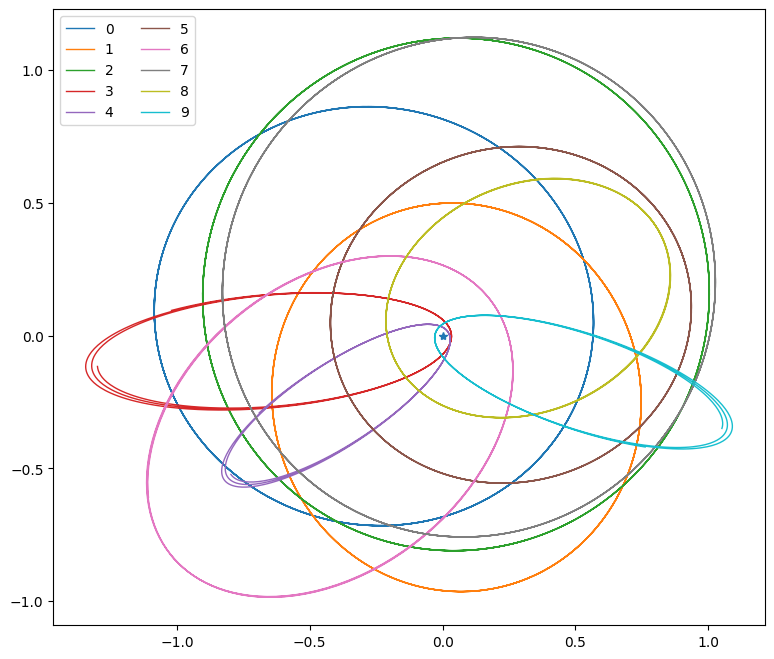

In [15]:
# Setup particle distribution
p=Particles(n=10,rad=1.,dispersion=0.2,edispersion=0.7)

# Print some statistics
p.energy(); p.radius(); p.speed()
print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))

# Setup integrator
I = Integration(p,Integrator='kdk',Courant='acceleration', \
                  norbit=100,reflexive=0)

# if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
# If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
# use_constant_dt = True should not be used in the tasks below.
use_constant_dt = False

# Make lists to store data for plotting and analysis
# Important to use np.copy, because otherwise just a pointer to data is made
r = []; r.append(np.copy(p.r))                       # store position
v = []; v.append(np.copy(p.v))                       # store velocity
energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
ptime = [np.copy(I.time)]                            # store time
dt = [np.copy(I.dt)]                                 # store dt

# Set timestep at start of integration!
if use_constant_dt:
    I.courant(p)

# If set to True, store positions and velocities as a function of time in r, v
store_orbits_and_plot = True

# Integrate at least 1 orbit for all particles, but for maximum "use" seconds
# Notice that each particle integrates with its own timestep.
tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
used = 0.0     # Time used in seconds
use = 10.      # Max time used for integration of orbits in seconds
while (used < use and I.time.min() < tend):
    start = time()
    if not use_constant_dt:
        I.courant(p) # Set timestep at start of integration step
    I.step(p)
    used += time()-start
    
    # store energy, time, and dt
    p.energy(); energy.append(np.copy(p.E))
    ptime.append(np.copy(I.time))
    dt.append(np.copy(I.dt))
    
    # store orbit
    if store_orbits_and_plot:
       r.append(np.copy(p.r))
       v.append(np.copy(p.v))

# Performance timining
print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

# Transpose arrays to make it easier to plot and analyse afterwards
energy = np.array(energy).transpose(1,0)
ptime = np.array(ptime).transpose(1,0)
dt = np.array(dt).transpose(1,0)
if store_orbits_and_plot:
    r = np.array(r).transpose(2,1,0)
    v = np.array(v).transpose(2,1,0)

# Make figure with orbits of particles    
if store_orbits_and_plot:
    plt.figure(figsize=(11,8))
    for i in range(r.shape[0]):
        plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
    plt.plot([0],[0],marker='*')
    plt.legend(ncol=2)
    plt.axis('scaled')
    plt.show()

### ${\bf Task\ 2}$

#### __Task 2: Make the KDK have a time symmetrized dt__ 
As discussed in http://adsabs.harvard.edu/abs/1995ApJ...443L..93H a symplectic integrator with a variable timestep is not symplectic anymore. The simplest reason is that it is not time reversible, but the underlying Hamiltonian (e.g. the physical system) is. To improve on this, it has been suggested that if we instead define $\Delta t$ to be the average of $\Delta t$ at the start and end of the integration step
\begin{equation}
\Delta t = [ \Delta t(t_\textrm{old}) + \Delta t(t_\textrm{new}) ] / 2
\end{equation}
then the solution will be time-symmetric. One way to do this is after the KDK step to
recompute $\Delta t$ as $\Delta t(t_\textrm{new-1})$, construct a new $\Delta t$ as the average and then redo the KDK step with the new timestep. If needed, this can be iterated. In the above article they have shown excellent results. In this task you will implement this, so-called, reflexive timestep. In the `Integration` class there already is defined a variable `self.reflexive`. Test if it is larger than zero inside the `kdk` routine, and if it is the case recompute `self.dt` as the average of the old value of `self.dt` (remember to store it before recomputing) and the new value (`self.reflexive=1`). If `self.reflexive>1` the computation of an average $\Delta t$ is itereated several times to reach an even more time reversible integration path.

Choose a one of the particles. How does the secular error in the energy per orbit change as when using reflexive=0 and norbit=100 compared to (reflexive,norbit)=(1,50) and (2,33)? E.g. with a constant number of KDK evaluations.

In [16]:
class Integration2():
    def __init__(self, p, Integrator='kdk', Courant='acceleration', \
                          norbit=33, reflexive=2):
        """ Setup integrator. p is a particle class with particle data """
        self.norbit = norbit               # dt control: nr of steps for a single orbit 
        self.Cdt = 2.*np.pi / norbit       # corresponding criteria for acceleration dt CFL condition

        # if self.reflexive>0 then use "reflexive" nr of trial steps to determine a time-symmetric dt for adaptive timestep
        self.reflexive  = reflexive
        
        self.nstep = 0                     # iteration step
        self.time = np.zeros(p.n)          # time
        self.dt = np.zeros(p.n)            # dt
        self.GM = p.GM                     # Transfer granvitational mass

        # choose integration method
        if Integrator=='kdk':
            self.Int = self.kdk
        if Integrator=='rk3':
            self.Int = self.rk3
        
        # choose Courant condition method
        if Courant=='orbit':
            self.courant = self.courant_orbit
        if Courant=='acceleration':
            self.courant = self.courant_acceleration
        
    def acceleration(self,r):
        """ Compute the gravitational acceleration at positions r """
        rm = np.sqrt(np.sum(r**2,0))
        return -r*self.GM/(rm*rm*rm)
        
    def kick(self,p):
        """ Update the velocity with half a time step """
        p.v = p.v + (0.5*self.dt)*self.acceleration(p.r)

    def drift(self,p):
        """ Advance the positions with a time step """
        p.r = p.r + self.dt*p.v

    def kdk(self,p):
        """ Take a single Kick-Drift-Drift timestep """
        # if reflexive dt condition used, store old particle positions, velocities, and dts
        # remember to use "np.copy" to take a real copy of the variables.
        
        if self.reflexive > 0:                
            pos=np.copy(p.r)
            vel=np.copy(p.v)
            dts=np.copy(self.dt) #old dt
        
       
        self.kick(p)
        self.drift(p)
        self.kick(p)
        # if reflexive dt condition used, recompute dt, and
        # use averaged dt to redo the KDK step "self.reflexive" times
        # from stored positions and velocities
        if self.reflexive > 0:
            # make n more iteration for completeness
            for i in range(self.reflexive):
                self.courant(p)
                new_dt=np.copy(self.dt)
                self.dt=np.copy(new_dt+dts)/2
                p.r=np.copy(pos)
                p.v=np.copy(vel)
                self.kick(p)
                self.drift(p)
                self.kick(p)
     
        
    def rk3(self,p):
        """ Take a single 3rd order Runge-Kutta timestep. See e.g.
            http://www.mymathlib.com/diffeq/runge-kutta/runge_kutta_v1_3.html
            for algorithm """
        dr1 = self.dt * p.v
        dv1 = self.dt * self.acceleration(p.r)
        
        dr2 = self.dt * (p.v + 0.5 * dv1)
        dv2 = self.dt * self.acceleration(p.r + 0.5 * dr1)
        
        dr3 = self.dt * (p.v - dv1 + 2.*dv2)
        dv3 = self.dt * self.acceleration(p.r - dr1 + 2.*dr2)
        
        p.r += (dr1 + 4.*dr2 + dr3) / 6.
        p.v += (dv1 + 4.*dv2 + dv3) / 6.
        
    def courant_orbit(self,p):
        """ Determine dt such that norbit steps are taken to complete an orbit """
        P = p.Porbit()                       # Compute orbit time
        # See Porbit function: Unbound particles are set to have an orbit with the largest bound particle P / dt
        self.dt = P / self.norbit            # update dt
            
    def courant_acceleration(self,p):
        """ Determine dt based on acceleration and velocity """
        acc = np.sqrt(np.sum(self.acceleration(p.r)**2,0))
        p.speed()
        self.dt[:] = self.Cdt * p.vm / acc
        
    def step(self,p):
        """ Take a single timestep """
        self.Int(p)             # The integrator is selected with the "Integrator" option at init
        self.time += self.dt
        self.nstep += 1

Energy min, aver, max, std : -40.4 -28.7 -20.4 6.2
Radius min, aver, max, std : 0.91 1.09 1.32 0.14
Speed  min, aver, max, std : 1.23 3.67 5.39 1.67
11262.9 nanosec/particle-step
Number of particles=10 and integration steps=235: 
Min time=0.95599 and end time=0.94934: 


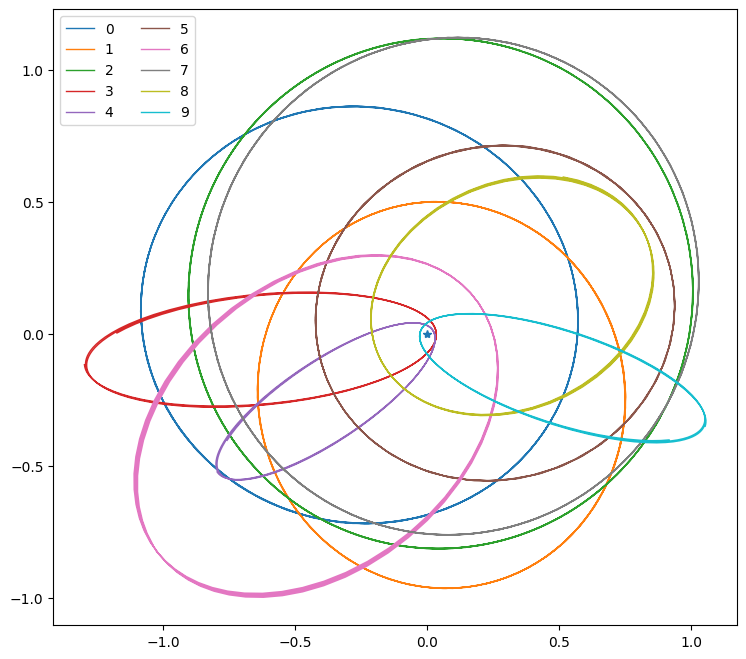

In [17]:
# Setup particle distribution
p=Particles(n=10,rad=1.,dispersion=0.2,edispersion=0.7)

# Print some statistics
p.energy(); p.radius(); p.speed()
print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))

# Setup integrator
I = Integration2(p,Integrator='kdk',Courant='acceleration', \
                  norbit=50,reflexive=1)

# if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
# If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
# use_constant_dt = True should not be used in the tasks below.
use_constant_dt = False

# Make lists to store data for plotting and analysis
# Important to use np.copy, because otherwise just a pointer to data is made
r = []; r.append(np.copy(p.r))                       # store position
v = []; v.append(np.copy(p.v))                       # store velocity
energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
ptime = [np.copy(I.time)]                            # store time
dt = [np.copy(I.dt)]                                 # store dt
# Set timestep at start of integration!
if use_constant_dt:
    I.courant(p)

# If set to True, store positions and velocities as a function of time in r, v
store_orbits_and_plot = True

# Integrate at least 1 orbit for all particles, but for maximum "use" seconds
# Notice that each particle integrates with its own timestep.
tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
used = 0.0     # Time used in seconds
use = 10.      # Max time used for integration of orbits in seconds
while (used < use and I.time.min() < tend):
    start = time()
    if not use_constant_dt:
        I.courant(p) # Set timestep at start of integration step
    I.step(p)
    used += time()-start
    
    # store energy, time, and dt
    p.energy(); energy.append(np.copy(p.E))
    ptime.append(np.copy(I.time))
    dt.append(np.copy(I.dt))
    
    # store orbit
    if store_orbits_and_plot:
       r.append(np.copy(p.r))
       v.append(np.copy(p.v))

# Performance timining
print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

# Transpose arrays to make it easier to plot and analyse afterwards
energy = np.array(energy).transpose(1,0)
ptime = np.array(ptime).transpose(1,0)
dt = np.array(dt).transpose(1,0)
if store_orbits_and_plot:
    r = np.array(r).transpose(2,1,0)
    v = np.array(v).transpose(2,1,0)
# Make figure with orbits of particles    
if store_orbits_and_plot:
    plt.figure(figsize=(11,8))
    for i in range(r.shape[0]):
        plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
    plt.plot([0],[0],marker='*')
    plt.legend(ncol=2)
    plt.axis('scaled')
    plt.show()

Cdt : 0.12566370614359174
Initial eccentricity : 0.7089817842340966
Initial energy:  -25.63676630022128
Average energy as a function of time:  -25.59093396689664
Std dev energy as a function of time:  0.16736831884605155


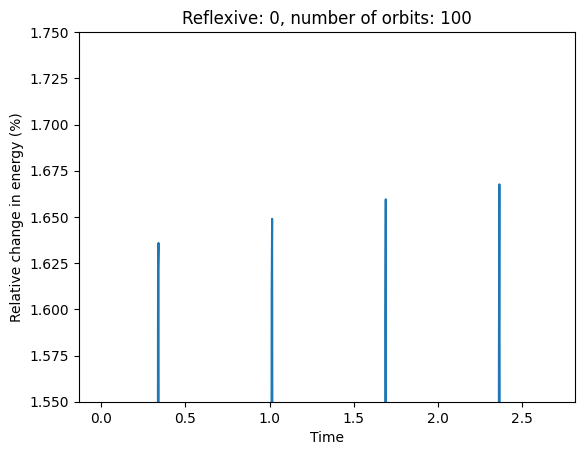

In [18]:
i_particle=6 # select particle track to plot energy for. Uses labels above. #seed=42 and i particle is 3 for the notebook pdf !!! self.vm=np.sqrt(GM*(1-self.e)/(self.rm)
plt.plot(ptime[i_particle],(energy[i_particle] / energy[i_particle,0]-1.)*100.)
plt.xlabel('Time')
plt.ylabel('Relative change in energy (%)')
plt.title('Reflexive: 0, number of orbits: 100')
plt.ylim((1.55,1.75))
# Information about run
print("Cdt :", I.Cdt)
print("Initial eccentricity :", p.e[i_particle])
print("Initial energy: ",energy[i_particle,0])
print("Average energy as a function of time: ",np.mean(energy[i_particle]))
print("Std dev energy as a function of time: ",np.std(energy[i_particle]));

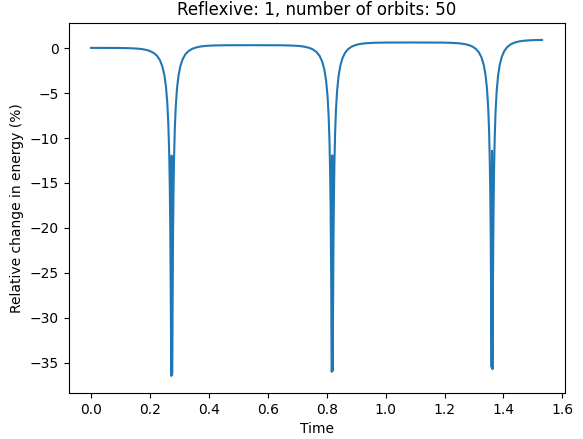

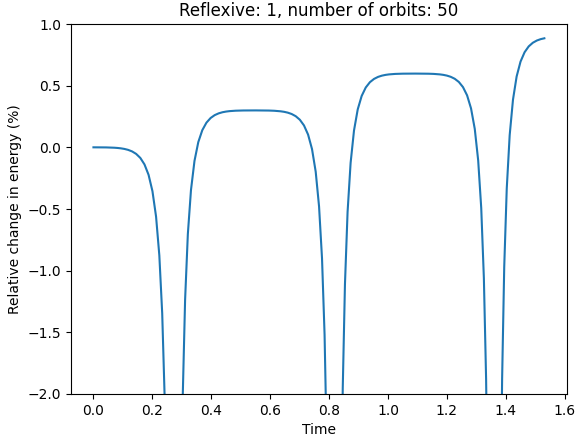

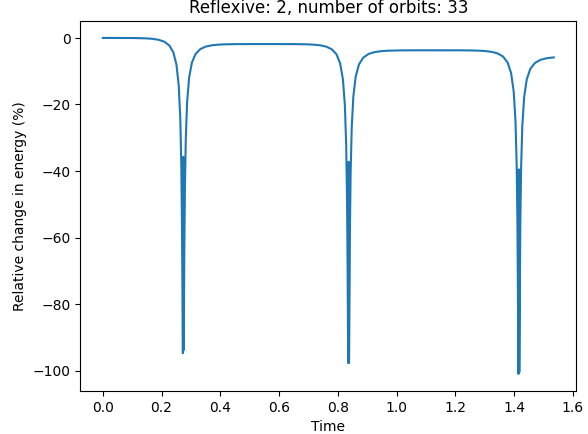

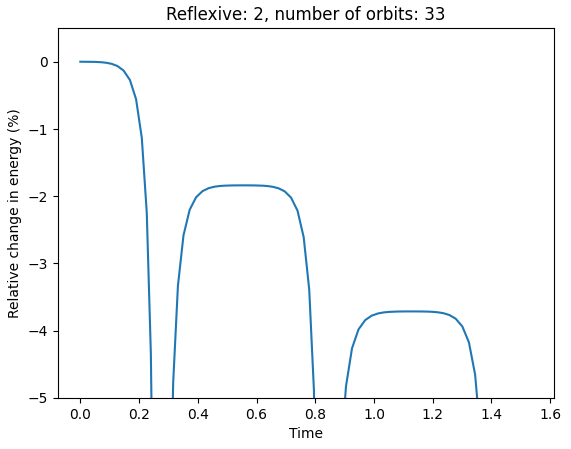

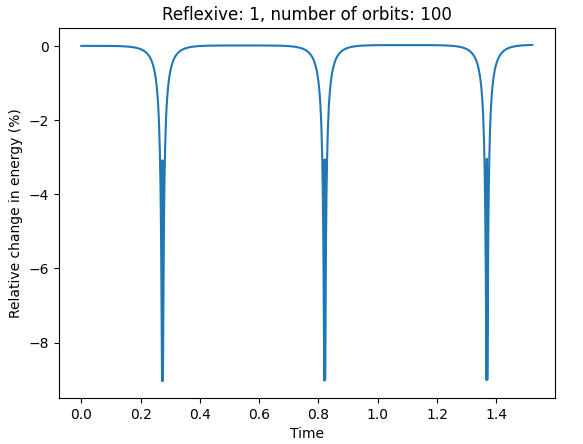

We run the programme for 100 orbits and the value of reflexive equals zero. We see that there is a worth noting increase in the relative change in energy. On the other hand when we increase the value of reflexive, things seems to change a little bit. Specifically, the relative change seems to be the same-sustained across the time. Though, whether we have a closer look, it is obvious that there are small differences. Particularly, in the case of (1,50) the change in energy is increasing, while in the case of (2,33) is decreasing. All in all, the relative change in energy is definitely smaller if we compare it with the case of reflexive number=0 and a better conservation in terms of energy is achieved Finally, if we set the reflexive number equals to 1 and set number of orbits 100, we could see that relative energy change is significantly reserved at first site.

### ${\bf Task\ 3}$

### __Task 3: Investigate fluctuations in energy__ 
Use the setup to integrate 50 particles forward in time, and investigate how changes in particle energy depend on the norbit parameter, which controls the timestep. Note that with the reflexive option active (set to a small value of e.g. 1), fewer updates is needed to reach the same accuracy. Take note of the values printed in the three cases (KDK with reflexive=0, KDK with reflexive=1 and RK3).

Think about how to measure the secular error in the energy as a function of orbits (e.g. time). Once you have decided on how to measure the error, make a log-log plot showing the error in the energy normalised to the initial orbital energy, as a function of norbit=[100,200,400,1000] (decrease norbit with a factor of 2 for reflexive=1 to reflect the extra cost of each integration step). It may be an advantage to turn off the storage and plotting of orbits to speed up the integration by setting store_orbits_and_plot = False. Comment on the result.

In [19]:
# Setup particle distribution
p=Particles(n=50,rad=1.,dispersion=0.2,edispersion=0.7)

# Print some statistics
p.energy(); p.radius(); p.speed()
print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))

# Setup integrator
print(p.n)
no=[1000]
relative_energy=np.zeros((len(no),p.n))
for index,count in enumerate(no):
    I = Integration2(p,Integrator='kdk',Courant='acceleration', \
                      norbit=count,reflexive=0)

    # if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
    # If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
    # use_constant_dt = True should not be used in the tasks below.
    use_constant_dt = False

    # Make lists to store data for plotting and analysis
    # Important to use np.copy, because otherwise just a pointer to data is made
    r = []; r.append(np.copy(p.r))                       # store position
    v = []; v.append(np.copy(p.v))                       # store velocity
    energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
    ptime = [np.copy(I.time)]                            # store time
    dt = [np.copy(I.dt)]                                 # store dt
    # Set timestep at start of integration!
    if use_constant_dt:
        I.courant(p)

    # If set to True, store positions and velocities as a function of time in r, v
    store_orbits_and_plot = False

    # Integrate at least 1 orbit for all particles, but for maximum "use" seconds
    # Notice that each particle integrates with its own timestep.
    tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
    used = 0.0     # Time used in seconds
    use = 10.      # Max time used for integration of orbits in seconds
    while (used < use and I.time.min() < tend):
        start = time()
        if not use_constant_dt:
            I.courant(p) # Set timestep at start of integration step
        I.step(p)
        used += time()-start

        # store energy, time, and dt
        p.energy(); energy.append(np.copy(p.E))
        ptime.append(np.copy(I.time))
        dt.append(np.copy(I.dt))

        # store orbit
        if store_orbits_and_plot:
           r.append(np.copy(p.r))
           v.append(np.copy(p.v))
    
    


    # Performance timining
    print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
    print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
    print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

    # Transpose arrays to make it easier to plot and analyse afterwards
    energy = np.array(energy).transpose(1,0)
    ptime = np.array(ptime).transpose(1,0)
    dt = np.array(dt).transpose(1,0)
    if store_orbits_and_plot:
        r = np.array(r).transpose(2,1,0)
        v = np.array(v).transpose(2,1,0)
    # Make figure with orbits of particles    
    if store_orbits_and_plot:
        plt.figure(figsize=(11,8))
        for i in range(r.shape[0]):
            plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
        plt.plot([0],[0],marker='*')
        plt.legend(ncol=2)
        plt.axis('scaled')
        plt.show()
    for j in range(p.n):
        re=np.copy((energy[j] / energy[j][0]-1.)*100)
        if abs(np.min(re))>=abs(np.max(re)):
            re=np.copy(-re)#inverse the figure
            re=re[re>0]
            peaks, _ = find_peaks(re)#find the peaks
            relative_energy[index][j]+=abs(-np.max(re)+re[peaks[0]])

        else:
            re=re[re>0]
            peaks, _ = find_peaks(re)
            relative_energy[index][j]+=abs(np.max(re)-re[peaks[0]])
    

Energy min, aver, max, std : -58.7 -31.0 -18.0 9.2
Radius min, aver, max, std : 0.61 0.95 1.37 0.18
Speed  min, aver, max, std : 1.41 4.61 7.14 1.65
50
686.8 nanosec/particle-step
Number of particles=50 and integration steps=8465: 
Min time=1.1481 and end time=1.148: 


In [20]:
rt=np.zeros(np.shape(relative_energy)[0])

for i in range(np.shape(relative_energy)[0]):
    rt[i]+=np.sum(relative_energy[i])/p.n
print(rt)

[0.00094232]


In [21]:
r0=np.zeros(4)
r0[0]+=1.00984163
r0[1]+=0.11931865
r0[2]+=0.01476239
r0[3]+=0.00094232

## Reflexive=1

In [22]:
# Setup particle distribution
p=Particles(n=50,rad=1.,dispersion=0.2,edispersion=0.7)

# Print some statistics
p.energy(); p.radius(); p.speed()
print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))

# Setup integrator
no=[50]
relative_energy=np.zeros((len(no),p.n))
for i in range(len(no)):
    I = Integration2(p,Integrator='kdk',Courant='acceleration', \
                      norbit=no[i],reflexive=1)

    # if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
    # If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
    # use_constant_dt = True should not be used in the tasks below.
    use_constant_dt = False

    # Make lists to store data for plotting and analysis
    # Important to use np.copy, because otherwise just a pointer to data is made
    r = []; r.append(np.copy(p.r))                       # store position
    v = []; v.append(np.copy(p.v))                       # store velocity
    energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
    ptime = [np.copy(I.time)]                            # store time
    dt = [np.copy(I.dt)]                                 # store dt
    # Set timestep at start of integration!
    if use_constant_dt:
        I.courant(p)

    # If set to True, store positions and velocities as a function of time in r, v
    store_orbits_and_plot = False

    # Integrate at least 1 orbit for all particles, but for maximum "use" seconds
    # Notice that each particle integrates with its own timestep.
    tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
    used = 0.0     # Time used in seconds
    use = 10.      # Max time used for integration of orbits in seconds
    while (used < use and I.time.min() < tend):
        start = time()
        if not use_constant_dt:
            I.courant(p) # Set timestep at start of integration step
        I.step(p)
        used += time()-start

        # store energy, time, and dt
        p.energy(); energy.append(np.copy(p.E))
        ptime.append(np.copy(I.time))
        dt.append(np.copy(I.dt))

        # store orbit
        if store_orbits_and_plot:
           r.append(np.copy(p.r))
           v.append(np.copy(p.v))
    
    


    # Performance timining
    print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
    print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
    print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

    # Transpose arrays to make it easier to plot and analyse afterwards
    energy = np.array(energy).transpose(1,0)
    ptime = np.array(ptime).transpose(1,0)
    dt = np.array(dt).transpose(1,0)
    if store_orbits_and_plot:
        r = np.array(r).transpose(2,1,0)
        v = np.array(v).transpose(2,1,0)
    # Make figure with orbits of particles    
    if store_orbits_and_plot:
        plt.figure(figsize=(11,8))
        for i in range(r.shape[0]):
            plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
        plt.plot([0],[0],marker='*')
        plt.legend(ncol=2)
        plt.axis('scaled')
        plt.show()
    for j in range(p.n):
        re=np.copy((energy[j] / energy[j][0]-1.)*100)
        if abs(np.min(re))>=abs(np.max(re)):
            re=np.copy(-re)#inverse the figure
            re=re[re>0]
            peaks, _ = find_peaks(re)#find the peaks
            relative_energy[i][j]+=abs(-np.max(re)+re[peaks[0]])

        else:
            re=re[re>0]
            peaks, _ = find_peaks(re)
            d=re[peaks[-1]]-re[peaks[-2]]
            if d>0:
                relative_energy[i][j]+=abs(re[peaks[-1]]-re[peaks[0]])
            else:
                relative_energy[i][j]+=abs(re[peaks[-2]]-re[peaks[0]])


Energy min, aver, max, std : -58.7 -31.0 -18.0 9.2
Radius min, aver, max, std : 0.61 0.95 1.37 0.18
Speed  min, aver, max, std : 1.41 4.61 7.14 1.65
1958.1 nanosec/particle-step
Number of particles=50 and integration steps=425: 
Min time=1.1506 and end time=1.148: 


In [23]:
rt=np.zeros(np.shape(relative_energy)[0])

for i in range(np.shape(relative_energy)[0]):
    rt[i]+=np.sum(relative_energy[i])/p.n
print(rt)

[0.0019842]


In [24]:
r1=np.zeros(4) #for no=[100,200,400,1000]
r1[0]+=0.00011626 #0.00326112
r1[1]+=7.60805929e-06 #0.00011626
r1[2]+=8.56491666e-07  #7.60805929e-06
r1[3]+=2.53408134e-08   #1.36437278e-07

In [25]:
r11=np.zeros(4) #for no=[50,100,200,500]
r11[0]+=0.0019842#0.00326112
r11[1]+=9.45308617e-05#0.00011626
r11[2]+=8.33355318e-06#7.60805929e-06
r11[3]+=2.19955058e-07#1.36437278e-07

## RK3

In [26]:
# Setup particle distribution
p=Particles(n=50,rad=1.,dispersion=0.2,edispersion=0.7)

# Print some statistics
p.energy(); p.radius(); p.speed()
print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))
no=[100]
relative_energy=np.zeros((len(no),p.n))
# Setup integrator
for index,count in enumerate(no):
    I = Integration2(p,Integrator='rk3',Courant='acceleration', \
                      norbit=count,reflexive=0)

    # if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
    # If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
    # use_constant_dt = True should not be used in the tasks below.
    use_constant_dt = False

    # Make lists to store data for plotting and analysis
    # Important to use np.copy, because otherwise just a pointer to data is made
    r = []; r.append(np.copy(p.r))                       # store position
    v = []; v.append(np.copy(p.v))                       # store velocity
    energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
    ptime = [np.copy(I.time)]                            # store time
    dt = [np.copy(I.dt)]                                 # store dt
    # Set timestep at start of integration!
    if use_constant_dt:
        I.courant(p)

    # If set to True, store positions and velocities as a function of time in r, v
    store_orbits_and_plot = False

    # Integrate at least 1 orbit for all particles, but for maximum "use" seconds
    # Notice that each particle integrates with its own timestep.
    tend = np.max(p.Porbit())  # Set tend to max period of orbit for any particle
    used = 0.0     # Time used in seconds
    use = 10.      # Max time used for integration of orbits in seconds
    while (used < use and I.time.min() < tend):
        start = time()
        if not use_constant_dt:
            I.courant(p) # Set timestep at start of integration step
        I.step(p)
        used += time()-start

        # store energy, time, and dt
        p.energy(); energy.append(np.copy(p.E))
        ptime.append(np.copy(I.time))
        dt.append(np.copy(I.dt))

        # store orbit
        if store_orbits_and_plot:
           r.append(np.copy(p.r))
           v.append(np.copy(p.v))
        

    # Performance timining
    print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
    print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
    print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

    # Transpose arrays to make it easier to plot and analyse afterwards
    energy = np.array(energy).transpose(1,0)
    ptime = np.array(ptime).transpose(1,0)
    dt = np.array(dt).transpose(1,0)
    if store_orbits_and_plot:
        r = np.array(r).transpose(2,1,0)
        v = np.array(v).transpose(2,1,0)
    # Make figure with orbits of particles    
    if store_orbits_and_plot:
        plt.figure(figsize=(11,8))
        for i in range(r.shape[0]):
            plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
        plt.plot([0],[0],marker='*')
        plt.legend(ncol=2)
        plt.axis('scaled')
        plt.show()
    for j in range(50):
        re=np.copy((energy[j] / energy[j][0]-1.)*100)
        peaks, _ = find_peaks((energy[j] / energy[j][0]-1.)*100)
        if peaks.size==0:
            relative_energy[index][j]=abs(re[-2]-re[1])  
        else:
            re=re[re>0]
            peaks, _ = find_peaks(re)
            relative_energy[index][j]+=abs(np.max(re)-re[peaks[0]])

Energy min, aver, max, std : -58.7 -31.0 -18.0 9.2
Radius min, aver, max, std : 0.61 0.95 1.37 0.18
Speed  min, aver, max, std : 1.41 4.61 7.14 1.65
1348.6 nanosec/particle-step
Number of particles=50 and integration steps=857: 
Min time=1.1504 and end time=1.148: 


In [27]:
rt=np.zeros(np.shape(relative_energy)[0])

for i in range(np.shape(relative_energy)[0]):
    rt[i]+=np.sum(relative_energy[i])/p.n
print(rt)


[0.75895634]


In [28]:
rk=np.zeros(4)
rk[0]+=0.75895634
rk[1]+=0.09250765
rk[2]+=0.01151032
rk[3]+=0.0007358

##### Here I am going to plot the secular error for the three different approaches, which have been discussed on the task 3.

In [29]:
r11=np.zeros(4) #for no=[50,100,200,500]
r11[0]+=0.0019842#0.00326112
r11[1]+=9.45308617e-05#0.00011626
r11[2]+=8.33355318e-06#7.60805929e-06
r11[3]+=2.19955058e-07#1.36437278e-07

In [30]:
r0=np.zeros(4)
r0[0]+=1.00984163
r0[1]+=0.11931865
r0[2]+=0.01476239
r0[3]+=0.00094232

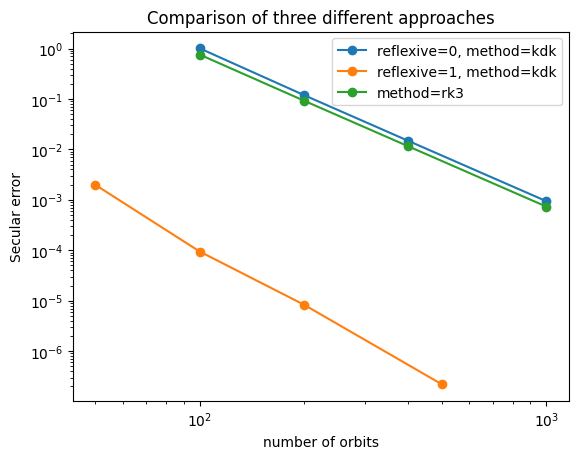

In [31]:
no=[100,200,400,1000]
noo=[50,100,200,500]
plt.yscale('log')
plt.loglog(no,r0,label='reflexive=0, method=kdk', marker='o')
plt.loglog(noo,r11,label='reflexive=1, method=kdk', marker='o')
plt.loglog(no,rk,label='method=rk3', marker='o')
plt.legend()
plt.title('Comparison of three different approaches')
plt.xlabel('number of orbits')
plt.ylabel('Secular error')
plt.show()

We compared three different methods for solving this particle system. Particularly, we investigated the relative change in energy of the system for a set of orbits e.g 100,200,400,1000 and for the case of kdk with reflexive=1 we created another set of orbits, e.g 50,100,200,500. Now, it is obvious that in the case of the kick-drift-kick procedure, where we have set the value of reflexive equal to one, the secular error is decreasing as we increase the number of orbits. Moreover, it is already smaller in comparison to the ones which are correlated to the cases of third order runge-kutta and kdk with reflexive=0. That means that the energy is somewhat better conserved while using this procedure. On the other hand, the secular error being produced by the rk3 is less than the kdk with reflexive=0, but the difference among them is pretty small.